In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


df_bangalore = pd.read_csv('/content/datasset1.csv')
df_hyderabad = pd.read_csv('/content/hydexcel.csv')


df_bangalore['buildings'] = df_bangalore['hospitals'] + df_bangalore['entertainment'] + df_bangalore['monuments']
df_hyderabad['buildings'] = df_hyderabad['hospitals'] + df_hyderabad['entertainment'] + df_hyderabad['monuments']


selected_features = ['popden', 'buildings', 'schools', 'rent', 'lat', 'long', 'railway', 'traffic ']
target_variable = 'metro'


missing_features_bangalore = set(selected_features) - set(df_bangalore.columns)
missing_features_hyderabad = set(selected_features) - set(df_hyderabad.columns)

if missing_features_bangalore or missing_features_hyderabad:
    raise ValueError(f"Missing features in the datasets. Bangalore: {missing_features_bangalore}, Hyderabad: {missing_features_hyderabad}")

# Function to clean and convert columns to numeric
def clean_and_convert_to_numeric(df, features):
    for feature in features:
        # Check if the column is of object type (likely strings)
        if df[feature].dtype == 'object':
            # Remove commas and convert to numeric, coercing errors to NaN
            df[feature] = df[feature].astype(str).str.replace(',', '').astype(float)
    return df

# Apply cleaning to both dataframes for selected features
df_bangalore = clean_and_convert_to_numeric(df_bangalore, selected_features)
df_hyderabad = clean_and_convert_to_numeric(df_hyderabad, selected_features)

df_bangalore_mean = df_bangalore[selected_features].mean()
df_bangalore[selected_features] = df_bangalore[selected_features] / df_bangalore_mean

df_hyderabad_mean = df_hyderabad[selected_features].mean()
df_hyderabad[selected_features] = df_hyderabad[selected_features] / df_hyderabad_mean


df_combined = pd.concat([df_bangalore, df_hyderabad], ignore_index=True)


subset_df = df_combined[selected_features]

correlation_matrix = subset_df.corr()

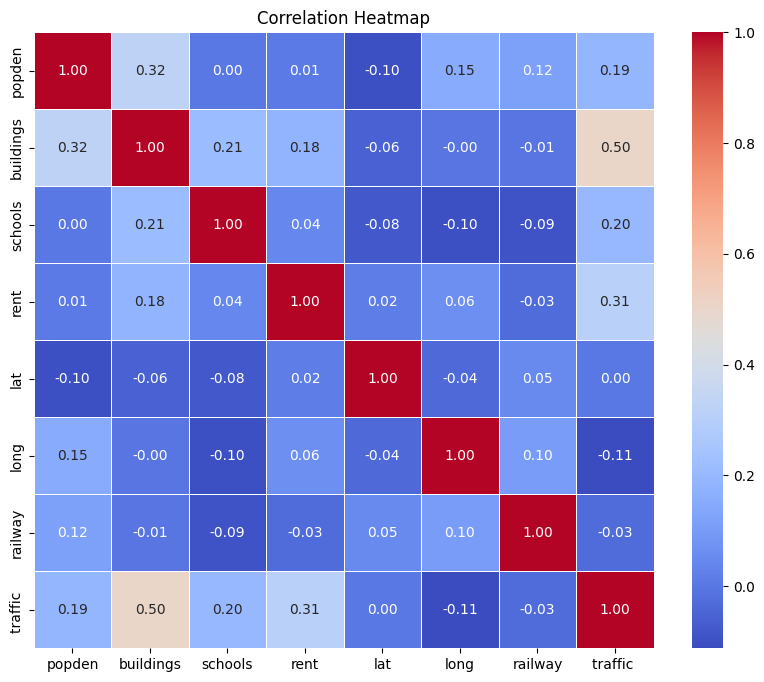

Combined Testing Accuracy: 0.8055555555555556
Combined Testing F1 Score: 0.8771929824561403


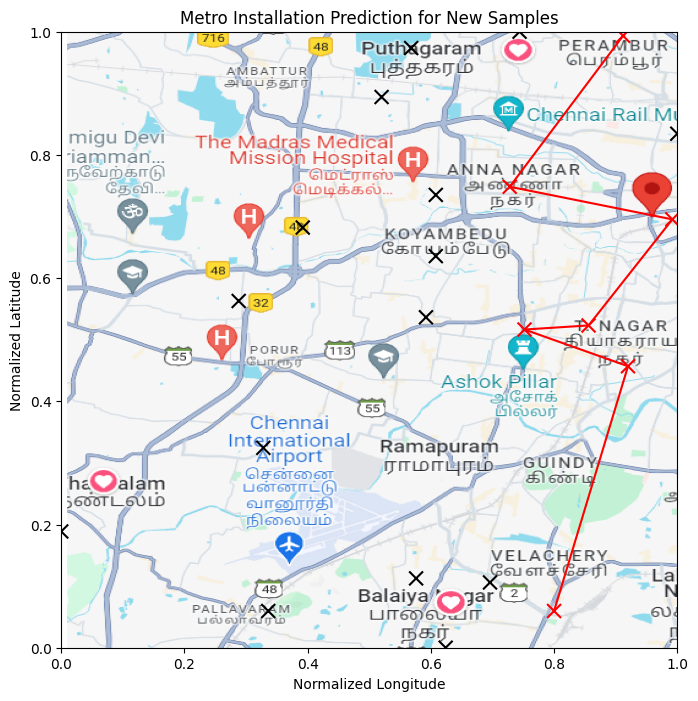

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


X_combined = df_combined[selected_features]
y_combined = df_combined[target_variable]

X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

rf_classifier_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_combined.fit(X_combined_train, y_combined_train)

y_combined_test_pred = rf_classifier_combined.predict(X_combined_test)
test_accuracy_combined = accuracy_score(y_combined_test, y_combined_test_pred)
test_f1_combined = f1_score(y_combined_test, y_combined_test_pred, pos_label='y')

print("Combined Testing Accuracy:", test_accuracy_combined)
print("Combined Testing F1 Score:", test_f1_combined)

new_samples = pd.read_csv('/content/chennaiexcel.csv')

new_samples[selected_features] = new_samples[selected_features] / new_samples[selected_features].mean()

scaler = MinMaxScaler()
new_samples[['lat', 'long']] = scaler.fit_transform(new_samples[['lat', 'long']])

predictions = rf_classifier_combined.predict(new_samples[selected_features])

red_crosses = new_samples[predictions == 'y'].sort_values(by=['lat', 'long'])

fig, ax = plt.subplots(figsize=(10, 8))

map_image = plt.imread('/content/chennai_final.png')

ax.imshow(map_image, extent=[0, 1, 0, 1])

ax.scatter(new_samples['long'], new_samples['lat'], c=['red' if pred == 'y' else 'black' for pred in predictions], marker='x', s=100)

for i in range(len(red_crosses) - 1):
    ax.plot([red_crosses['long'].iloc[i], red_crosses['long'].iloc[i + 1]],
            [red_crosses['lat'].iloc[i], red_crosses['lat'].iloc[i + 1]], color='red')

plt.title('Metro Installation Prediction for New Samples')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')

plt.show()

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

df_bangalore = pd.read_csv('/content/datasset1.csv')
df_hyderabad = pd.read_csv('/content/hydexcel.csv')

df_bangalore['buildings'] = df_bangalore['hospitals'] + df_bangalore['entertainment'] + df_bangalore['monuments']
df_hyderabad['buildings'] = df_hyderabad['hospitals'] + df_hyderabad['entertainment'] + df_hyderabad['monuments']

selected_features = ['popden', 'buildings', 'schools', 'rent', 'lat', 'long', 'railway', 'traffic ']
target_variable = 'metro'

missing_features_bangalore = set(selected_features) - set(df_bangalore.columns)
missing_features_hyderabad = set(selected_features) - set(df_hyderabad.columns)

if missing_features_bangalore or missing_features_hyderabad:
    raise ValueError(f"Missing features in the datasets. Bangalore: {missing_features_bangalore}, Hyderabad: {missing_features_hyderabad}")

# Function to clean and convert columns to numeric
def clean_and_convert_to_numeric(df, features):
    for feature in features:
        # Check if the column is of object type (likely strings)
        if df[feature].dtype == 'object':
            # Remove commas and convert to numeric, coercing errors to NaN
            df[feature] = df[feature].astype(str).str.replace(',', '').astype(float)
    return df

# Apply cleaning to both dataframes for selected features
df_bangalore = clean_and_convert_to_numeric(df_bangalore, selected_features)
df_hyderabad = clean_and_convert_to_numeric(df_hyderabad, selected_features)

df_bangalore_mean = df_bangalore[selected_features].mean()
df_bangalore[selected_features] = df_bangalore[selected_features] / df_bangalore_mean

df_hyderabad_mean = df_hyderabad[selected_features].mean()
df_hyderabad[selected_features] = df_hyderabad[selected_features] / df_hyderabad_mean

df_combined = pd.concat([df_bangalore, df_hyderabad], ignore_index=True)

df_combined['metro'] = df_combined['metro'].map({'y': 1, 'n': 0})

X_combined = df_combined[selected_features]
y_combined = df_combined[target_variable]

X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_combined_resampled, y_combined_resampled = oversampler.fit_resample(X_combined_train, y_combined_train)

Combined Testing Accuracy (XGBoost): 0.8611111111111112
Combined Testing F1 Score (XGBoost): 0.9122807017543859


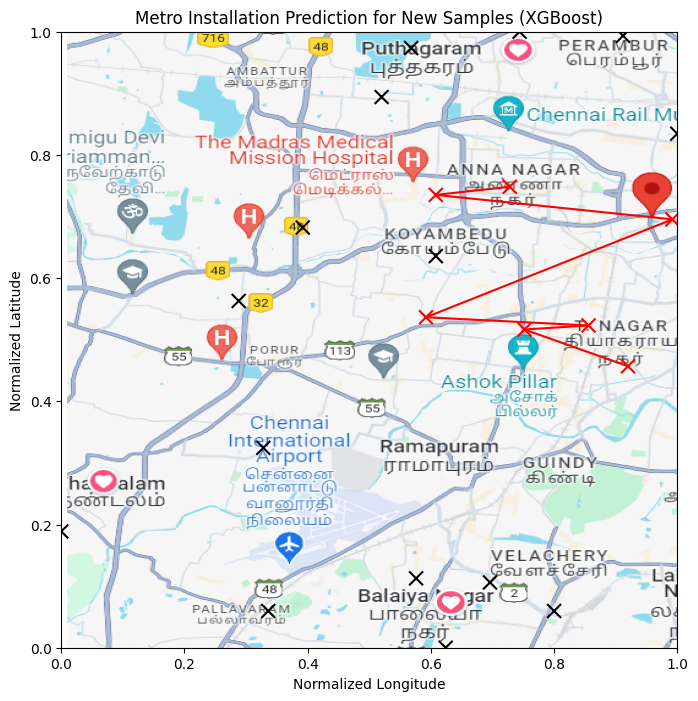

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
}

xgb_classifier = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_combined_resampled, y_combined_resampled)

best_xgb_classifier = grid_search.best_estimator_

y_combined_test_pred_xgb = best_xgb_classifier.predict(X_combined_test)
test_accuracy_combined_xgb = accuracy_score(y_combined_test, y_combined_test_pred_xgb)
test_f1_combined_xgb = f1_score(y_combined_test, y_combined_test_pred_xgb, pos_label=1)

print("Combined Testing Accuracy (XGBoost):", test_accuracy_combined_xgb)
print("Combined Testing F1 Score (XGBoost):", test_f1_combined_xgb)

new_samples = pd.read_csv('/content/chennaiexcel.csv')

new_samples[selected_features] = new_samples[selected_features] / new_samples[selected_features].mean()

scaler = MinMaxScaler()
new_samples[['lat', 'long']] = scaler.fit_transform(new_samples[['lat', 'long']])

predictions_xgb = best_xgb_classifier.predict(new_samples[selected_features])

red_crosses_xgb = new_samples[predictions_xgb == 1].sort_values(by=['lat', 'long'])

fig, ax = plt.subplots(figsize=(10, 8))

map_image = plt.imread('/content/chennai_final.png')

ax.imshow(map_image, extent=[0, 1, 0, 1])

ax.scatter(new_samples['long'], new_samples['lat'], c=['red' if pred == 1 else 'black' for pred in predictions_xgb], marker='x', s=100)

for i in range(len(red_crosses_xgb) - 1):
    ax.plot([red_crosses_xgb['long'].iloc[i], red_crosses_xgb['long'].iloc[i + 1]],
            [red_crosses_xgb['lat'].iloc[i], red_crosses_xgb['lat'].iloc[i + 1]], color='red')

plt.title('Metro Installation Prediction for New Samples (XGBoost)')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')

plt.show()